<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 2 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
        <th>Kaggle naam</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td><span style="color:blue">2</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
        <td><span style="color:blue">???</span></td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1 - EDA**](#eda)
- [**Opdracht 2 - LSTM voor audioclips**](#audio)
- [**Opdracht 3 - LSTM voor songteksten**](#song_lstm)
- [**Opdracht 4 - Transformer voor songteksten**](#song_tran)
- [**Opdracht 5 - Model naar keuze**](#mnk)
- [**Opdracht 6 - Bevindingen**](#bevindingen)
- [**Opdracht 7 - Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook gaan we aan de hand van songteksten en audiodata, audiotracks in verschillende genres classificeren

## Packages en de data inladen <a name='data'></a>

In [1]:
#!pip install datasets
#!pip install transformers
import os
import re
import nltk
from nltk.tokenize import word_tokenize
import string
import pathlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython.display import display
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Embedding, TextVectorization
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, create_optimizer, TFAutoModelForSequenceClassification
from datasets import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/Portfolio opdracht 2')

In [3]:
#songteksten inladen

train = pd.read_csv('train.csv', index_col='filename')
test = pd.read_csv('test.csv', index_col='filename')

In [5]:
#Train en validation set inladen

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Train',
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [45]:
#aantal labels

len(label_names)

8

In [7]:
# squeeze gebruiken om de extra as te verwijderen
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
#test dataset inladen

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Test',
    label_mode=None,
    batch_size=32,
    seed=0,
    output_sequence_length=5*16000)

print()

Found 129 files belonging to 1 classes.



In [9]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## **Opdracht 1 - EDA** <a name='eda'></a>

In [10]:
display(train.head())
display(train.describe())
display(train.isnull().sum())

,lyrics,genre
filename,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\r\nI'm in the ...,blues
blues.00002.wav,(John Lee Hooker)\r\nThink twice before you go...,blues
blues.00003.wav,"[Intro, Spoken]\r\n...A little thing I'm going...",blues
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
blues.00006.wav,My baby left me this morning\r\nPeople just ar...,blues


,lyrics,genre
count,537,537
unique,500,8
top,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,4,79


lyrics    0
genre     0
dtype: int64

Hier kunnen we zien dat er geen missende waardes in de data zijn. 

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

df_test = train.copy()
df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)
display(df_test)

,lyrics,genre,prep_text
filename,,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\r\nI'm in the ...,blues,i’m in the mood lyrics\r im in the mood baby i...
blues.00002.wav,(John Lee Hooker)\r\nThink twice before you go...,blues,john lee hooker\r think twice before you go ba...
blues.00003.wav,"[Intro, Spoken]\r\n...A little thing I'm going...",blues,\r a little thing im going to do called im bad...
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,sugar mama sugar mama sugar mama please come b...
blues.00006.wav,My baby left me this morning\r\nPeople just ar...,blues,my baby left me this morning\r people just aro...
...,...,...,...
rock.00094.wav,[Chorus]\r\nDon’t stop\r\nIsn’t it funny how y...,rock,\r don’t stop\r isn’t it funny how you shine\r...
rock.00096.wav,"[Verse 1]\r\nHer hair, soft drifted snow\r\nDe...",rock,\r her hair soft drifted snow\r death white id...
rock.00097.wav,[Verse 1]\r\nYour knuckles whiten on the wheel...,rock,\r your knuckles whiten on the wheel\r the las...


In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

def tokenize_text(text):
    return text.split()

def count_tokens(text):
    return Counter(text)

df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)

# Combine all lyrics
all_lyrics = ' '.join(df_test['prep_text'])

# Tokenize combined text
all_tokens = tokenize_text(all_lyrics)

# Count occurrences of each token
token_counts = count_tokens(all_tokens)

# Get the most common tokens
most_common_all_genres = token_counts.most_common(20)  # You can adjust this number as needed


grouped_by_genre = df_test.groupby('genre')

#Calculate frequency distribution of tokens and extract most common tokens per genre
most_common_per_genre = {}
for genre, group in grouped_by_genre:
    all_tokens = [token for text in group['prep_text'] for token in tokenize_text(text)]
    token_counts = count_tokens(all_tokens)
    most_common = token_counts.most_common(20)  # You can adjust this number as needed
    most_common_per_genre[genre] = most_common

In [13]:
max_count = max(max(sublist[1] for sublist in sublist_list) for sublist_list in most_common_per_genre.values())
x_ticks = np.arange(0, max_count + 1, 100)

# Plot most common tokens per genre
for genre, common_tokens in most_common_per_genre.items():
    tokens, counts = zip(*common_tokens)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=tokens, ci=None)
    plt.title(f"Most Common Tokens in {genre}")
    plt.xlabel("Frequency")
    plt.ylabel("Token")
    plt.xticks(x_ticks, rotation=90)
    plt.show()

# Plot most common tokens across all genres
tokens_all, counts_all = zip(*most_common_all_genres)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts_all, y=tokens_all, ci=None)
plt.title("Most Common Tokens Across All Genres")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

AttributeError: 'bool' object has no attribute 'all'

<Figure size 720x432 with 0 Axes>

(32, 80000)
(32,)


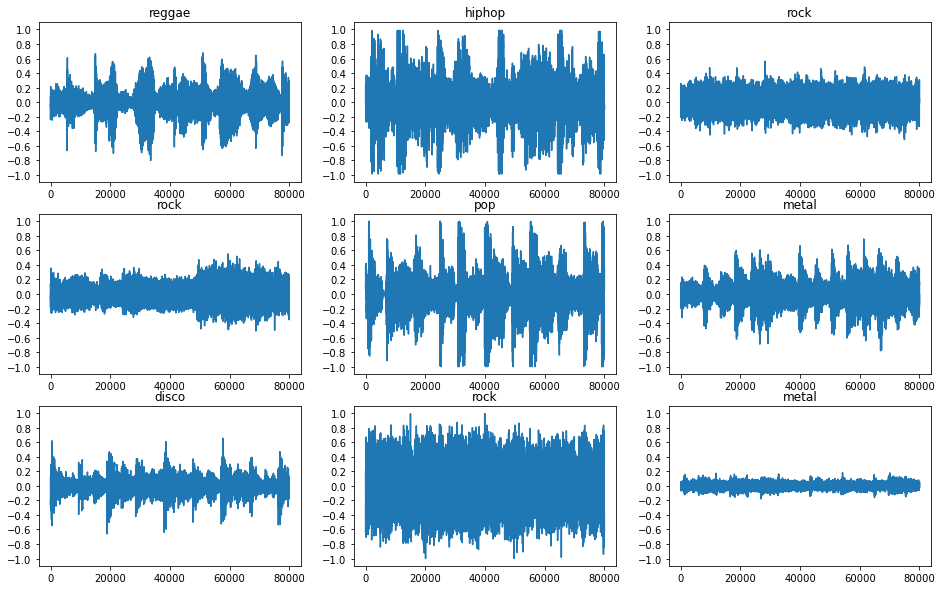

In [14]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[1,1,0,0]]
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

Hier zie je de golfvormen van verschillende genres, wat ons opvalt is dat je verschil ziet in de golfvormen van de verschillende genres. Dit is erg handig want hierdoor kan het model waarschijnlijk ook beter onderscheid maken tussen de genres. 

## Opdracht 2 - LSTM voor audioclips <a name='audio'></a>

Voor feature engineren hebben wij ervoor gekozen om Mel-frequency cepstral coefficients (mfcc) toe te passen. MFCC's zijn een compact aantal eigenschappen die de algemene vorm van het frequentiespectrum van een geluidssignaal samenvatten. 
We hebben voor MFCC gekozen omdat deze robuust zijn tegen veranderingen in toonhoogte en luidheid, dit is handig aangezien de verschillende genres kunnen varieren in toonhoogte. Ook kunnen MFCC's helpen bij het vastleggen van subtiele verschillen in klankkleur. MFCC's helpen ook bij het verminderen van ruis en onnodige details in de audiodata. 
(Deruty, 2022)

De code hieronder komen voor een groot deel uit de lesopdracht  'LSTM_voor_timeseries_data_–_classificatie_van_audioclips'

In [15]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [16]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [18]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio: (get_spectrogram(audio),),  # Geen label doorgeven
      num_parallel_calls=tf.data.AUTOTUNE)

test_spectrogram_ds = make_spec_ds(test_ds)


In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [21]:
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram,label: (spectrogram_to_mfcc(spectrogram), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

In [23]:
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram: (spectrogram_to_mfcc(spectrogram)),
      num_parallel_calls=tf.data.AUTOTUNE)

test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds)

In [24]:
train_MFCC_ds = train_MFCC_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

## LSTM

We hebben verschillende LSTM modellen getrainen om te kijken welke het beste werkt. 
Voor optimizer hebben wij gekozen voor ADAM, deze past de leersnelheid van elk parametergewicht aan op basis van de schattingen van het eerste moment en het tweede moment van de gradiënte. (Team, z.d.) 
De loss functie waar wij gebruik van maken is de SparseCategoricalCrossentropy. Deze wordt gebruikt bij het categoriseren van 2 of meerdere label classen. (Team, z.d.-b)
Daarnaast hebben we gekozen voor een Early stopping met een patience van 20 zodat het trainingsproces vroegtijdig stopt als er gedurende een bepaald aantal epochs geen verbetering meer is in de vall los van het model. Hierdoor voorkom je overfitten en het bespaart ook tijd met het trainen. 

In [31]:
#LSTM model 1

model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])


In [32]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [33]:
model_lstm.summary()


ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Dit LSTM-model bestaat uit meerdere lagen:

Een bidirectionele laag met 64 units. De laag stelt het model in staat om zowel naar voren als naar achteren door de gegevenssequentie te kijken. Hier door krijgt het model een dieper begrip kan krijgen van de context van de invoergegevens.
Een dropout-laag met een dropout-waarde van 0.20, wat betekent dat tijdens het trainen 20% van de getrainde gegevens wordt uitgeschakeld om overfitting te voorkomen.
Een tweede bidirectionele laag met 32 units. Deze laag bouwt voort op de eerdere bidirectionele laag en verfijnt de representaties verder.
Opnieuw een dropout-laag met een dropout-waarde van 0.20 om overfitting te verminderen.
Tot slot een dense laag met 8 uitgangen, aangezien er 8 verschillende muziekgenres zijn die voorspeld moeten worden. De softmax-activatiefunctie wordt gebruikt om de kansverdeling over de verschillende klassen te berekenen.

In [34]:
EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

best_val_score = min(history.history['val_loss'])  
best_loss = min(history.history['loss']) 
print("Beste validatiescore:", best_val_score)
print("Beste trainingsloss:", best_loss)

Epoch 1/50
14/14 [==============================] - 28s 732ms/step - loss: 2.0144 - accuracy: 0.2023 - val_loss: 1.8704 - val_accuracy: 0.2804
Epoch 2/50
14/14 [==============================] - 6s 451ms/step - loss: 1.7714 - accuracy: 0.3581 - val_loss: 1.7218 - val_accuracy: 0.3178
Epoch 3/50
14/14 [==============================] - 6s 455ms/step - loss: 1.6151 - accuracy: 0.4256 - val_loss: 1.6594 - val_accuracy: 0.3645
Epoch 4/50
14/14 [==============================] - 6s 459ms/step - loss: 1.4959 - accuracy: 0.4767 - val_loss: 1.5956 - val_accuracy: 0.3645
Epoch 5/50
14/14 [==============================] - 6s 450ms/step - loss: 1.3623 - accuracy: 0.5674 - val_loss: 1.5653 - val_accuracy: 0.4019
Epoch 6/50
14/14 [==============================] - 6s 465ms/step - loss: 1.2741 - accuracy: 0.5442 - val_loss: 1.5431 - val_accuracy: 0.4112
Epoch 7/50
14/14 [==============================] - 6s 465ms/step - loss: 1.2299 - accuracy: 0.5698 - val_loss: 1.4800 - val_accuracy: 0.4579
Epoch

In [35]:
#LSTM model 2

model_lstm_2 = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32, return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(units=16)),  
    Dropout(0.2),
    Dense(64, activation='relu'),  
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50
history_2 = model_lstm_2.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

best_val_score_2 = min(history_2.history['val_loss'])  
best_loss_2 = min(history_2.history['loss']) 
print("Beste validatiescore:", best_val_score_2)
print("Beste trainingsloss:", best_loss_2)

Epoch 1/50
14/14 [==============================] - 43s 1s/step - loss: 2.0583 - accuracy: 0.1535 - val_loss: 1.9985 - val_accuracy: 0.2336
Epoch 2/50
14/14 [==============================] - 9s 685ms/step - loss: 1.9308 - accuracy: 0.2674 - val_loss: 1.9000 - val_accuracy: 0.3178
Epoch 3/50
14/14 [==============================] - 10s 708ms/step - loss: 1.8052 - accuracy: 0.3791 - val_loss: 1.7924 - val_accuracy: 0.3364
Epoch 4/50
14/14 [==============================] - 10s 709ms/step - loss: 1.6959 - accuracy: 0.3930 - val_loss: 1.7008 - val_accuracy: 0.3738
Epoch 5/50
14/14 [==============================] - 10s 705ms/step - loss: 1.5989 - accuracy: 0.4372 - val_loss: 1.6945 - val_accuracy: 0.3738
Epoch 6/50
14/14 [==============================] - 10s 694ms/step - loss: 1.4930 - accuracy: 0.4558 - val_loss: 1.6455 - val_accuracy: 0.4112
Epoch 7/50
14/14 [==============================] - 9s 671ms/step - loss: 1.4242 - accuracy: 0.5186 - val_loss: 1.6525 - val_accuracy: 0.3832
Epoc

AttributeError: 'History' object has no attribute 'history_2'

In [42]:
#LSTM model 3

model_lstm_3 = models.Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model_lstm_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history_3 = model_lstm_3.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

best_val_score_3 = min(history_3.history['val_loss'])  
best_loss_3 = min(history_3.history['loss'])  
print("Beste validatiescore:", best_val_score_3)
print("Beste trainingsloss:", best_loss_3)

Epoch 1/50
14/14 [==============================] - 49s 1s/step - loss: 2.0079 - accuracy: 0.2302 - val_loss: 1.8602 - val_accuracy: 0.3925
Epoch 2/50
14/14 [==============================] - 15s 1s/step - loss: 1.8293 - accuracy: 0.2907 - val_loss: 1.7482 - val_accuracy: 0.4206
Epoch 3/50
14/14 [==============================] - 15s 1s/step - loss: 1.7335 - accuracy: 0.3419 - val_loss: 1.7070 - val_accuracy: 0.4019
Epoch 4/50
14/14 [==============================] - 14s 1s/step - loss: 1.6589 - accuracy: 0.3953 - val_loss: 1.6550 - val_accuracy: 0.3925
Epoch 5/50
14/14 [==============================] - 14s 1s/step - loss: 1.5293 - accuracy: 0.4000 - val_loss: 1.5920 - val_accuracy: 0.4299
Epoch 6/50
14/14 [==============================] - 14s 1s/step - loss: 1.4930 - accuracy: 0.4605 - val_loss: 1.5804 - val_accuracy: 0.3551
Epoch 7/50
14/14 [==============================] - 14s 1s/step - loss: 1.3864 - accuracy: 0.4814 - val_loss: 1.5487 - val_accuracy: 0.4112
Epoch 8/50
14/14 [==

LSTM Model 1: Validatiescore = 1.4518, Trainingsloss = 0.1838

LSTM Model 2: Validatiescore = 1.6114, Trainingsloss = 0.5590

LSTM Model 3: Validatiescore = 1.4859, Trainingsloss = 0.2921

LSTM Model 1 heeft de laagste validatiescore en de laagste trainingsloss, wat suggereert dat het het beste presteert van de drie modellen. Dus model 1 lijkt het beste te zijn op basis van deze metingen.

Text(0, 0.5, 'Accuracy [%]')

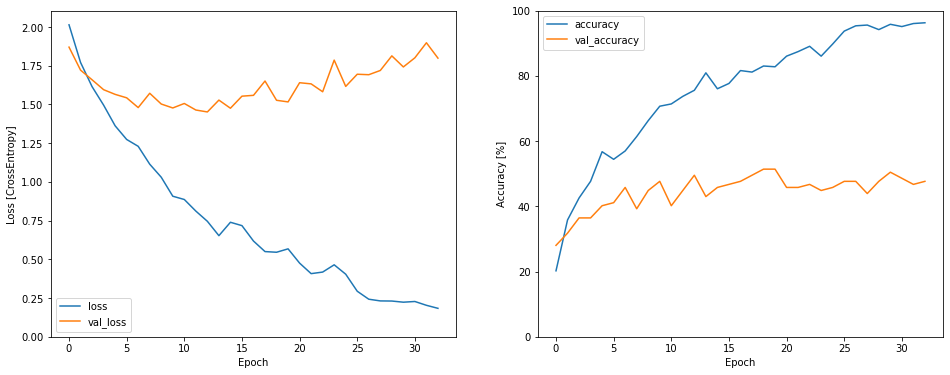

In [44]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 3 - LSTM voor songteksten <a name='song_lstm'></a>

Alle code is gemaakt met behulp van ChatGPT.  
[ChatGPT, Prompt: Preprocess text](https://chat.openai.com/share/23851467-f3c1-4ab7-a520-ce6f3e93bc8d)  
[ChatGPT, Prompt: LSTM Model Input Error](https://chat.openai.com/share/87bf7e53-56c5-4fd7-ac24-236f9f47ebf9)  
[ChatGPT, Prompt: Lower text](https://chat.openai.com/share/3d02c6cd-6317-4eb8-a171-864d7a67873c)  
[ChatGPT, Prompt: Model error](https://chat.openai.com/share/1ab1e7fb-5b2f-41c9-8c28-182b9d584c50)  
[ChatGPT, Prompt: Text Preprocessing & Embedding](https://chat.openai.com/share/14b384fc-55f4-4ef3-b5df-699f256dc903)  
[ChatGPT, Prompt: Preprocess Text: Corrections Made](https://chat.openai.com/share/9a0924be-1a99-4e08-b269-fa10cb08b4b1)  
[ChatGPT, Prompt: Overfitting indicated by loss and accuracy score](https://chat.openai.com/share/fc5c120f-dc1f-4203-ab43-9c111367aeb3)  



De dataframe heeft als index de filename en de kollomen zijn lyrics en genre. We maken gebruik van LabelEncoder om een encoded genre te maken, zodat de target/labels numeriek zijn.

In [ ]:
genres = list(set(train['genre']))

label_encoder = LabelEncoder()

# Fit label encoder and transform the genre labels into numbers
encoded_labels = label_encoder.fit_transform(genres)

# Print the mapping between genres and encoded labels
label_mapping = dict(sorted(zip(genres, encoded_labels)))
print("Label mapping:", label_mapping)

train['genre_encoded'] = train['genre'].map(label_mapping)

display(train)

In [ ]:
def df_to_dataset(dataframe, target, num_classes, batch_size=32, shuffle=True):
    '''Takes a dataframe with lyrics, target and number of classes to turn them to a training and validation dataset.

    Parameters:
    -----------
      dataframe: Dataframe.
      target: str, target column (labels).
      num_classes: int, amount of set classes.

    Returns:
    --------
      train_ds: tensorflow.python.data.ops.batch_op._BatchDataset, training dataset.
      val_ds: tensorflow.python.data.ops.batch_op._BatchDataset, validation dataset.
    '''
    dataframe = dataframe.copy()
    if shuffle:
      dataframe = dataframe.reset_index().sample(frac=1).set_index('filename')

    train_size = int(0.8 * len(dataframe))

    # Split dataframe into training and validation sets
    train_df = dataframe[:train_size]
    val_df = dataframe[train_size:]
    train_labels = to_categorical(train_df.pop(target), num_classes)
    val_labels = to_categorical(val_df.pop(target), num_classes)

    train_ds = tf.data.Dataset.from_tensor_slices((train_df['lyrics'].values, train_labels))
    train_ds = train_ds.batch(batch_size)

    val_ds = tf.data.Dataset.from_tensor_slices((val_df['lyrics'].values, val_labels))
    val_ds = val_ds.batch(batch_size)
    return train_ds, val_ds

In [ ]:
dataframe = train[['lyrics', 'genre_encoded']]
num_classes = len(set(dataframe['genre_encoded']))
train_text_ds, val_text_ds = df_to_dataset(dataframe, 'genre_encoded', num_classes)

Voor de vectorize layer is er een custom_standardization functie gemaakt om de lyrics te preprocessen. De preprocessing bestaat uit:  
1. Alles uit de text tot klein letters gemaakt.
2. Alle new lines (\n) verplaats met een spatie.
3. Alles in rechte haakjes verplaats met een spatie (Er wordt in rechte haakjes de Chorus, Verse of andere termen gewezen).
4. Alle leestekens weggehaald.  
  
We hebben dan schonere teksten voor de vectorize layer, met max_tokens en output_sequence_length hopen we voor een goede kwaliteit van de vectorize layer.  
De embedding layer is om voor elk woord een dense vector te maken, zodat de woorden een connectie hebben met elkaar.


In [ ]:
def custom_standardization(text):
    # Lowercase text
    text = tf.strings.lower(text)
    # Remove new lines
    text = tf.strings.regex_replace(text, r'\n', ' ')
    # Remove anything in square brackets
    text = tf.strings.regex_replace(text, r'\[.*?\]', '')
    # Remove punctuation
    punctuation = string.punctuation
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(punctuation), '')
    return text

vocab_size = 10000
sequence_length = 120

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_text_ds.map(lambda x, y: x)
text_ds = text_ds.unbatch()  # Unbatch the dataset to get individual text samples

# Extract the text data from the dataset
texts = [text.numpy().decode('utf-8') for text in text_ds]
vectorize_layer.adapt(texts)

embedding_layer = Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64, mask_zero=True)

In [ ]:
model_text_lstm = Sequential([
    vectorize_layer,
    embedding_layer,
    GRU(128, return_sequences=True, dropout=0.2),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_text_lstm.summary()

Het model bestaat eerst uit vectorized_layer en embedding_layer, daarna hebben we willekeurig een GRU en Bidrectional met LSTM layers geplaatst. Dan een Dense naar een output met softmax als activation, omdat we te maken hebben met multiple classes. In dit geval 8.

In [ ]:
epochs=5000

# Compile
model_text_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

# Add early stopping to the tuning process
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
history = model_text_lstm.fit(train_text_ds,
                              batch_size = 32,
                                validation_data=val_text_ds,
                                epochs=epochs,
                                callbacks=[stop_early])

Willekeurig 5000 epochs gekozen om te zien hoe ver de training gaat. De EarlyStopping monitor de val_loss en heeft de training gestopt, omdat het al zakte. Maar de val_accuracy is heel laag.

## Opdracht 4 - Transformer voor songteksten <a name='song_tran'></a>

## BERT model
Voor deze opdracht gebruiken wij het BERT model, dit is een vrij klein model wat goed is omdat het lokaal gerunt kan worden. Ook is het een transformer model dat getrained is op een grote dataset van text waardoor het model goede generalisaties in text kan herkennen en dus beter is in het voorspellen van genres gebaseerd op lyrics. Het model gebruikt de voorgetrainde kennis om de voorspellingen goed uit te kunnen voeren zonder hier enorme hoeveelheden data voor nodig te hebben. (Google-bert/Bert-base-uncased · Hugging Face, 2001)

### Modelnaam
model: bert-base-uncased

### Training data
Het BERT-model werd vooraf getraind op BookCorpus, een dataset bestaande uit 11.038 niet-gepubliceerde boeken en de Engelstalige Wikipedia (zonder lijsten, tabellen en kopteksten). (Google-bert/Bert-base-uncased · Hugging Face, 2001)

BookCorpus: https://yknzhu.wixsite.com/mbweb (Home | Mbweb, z.d.)<br>
English Wikipedia: https://en.wikipedia.org/wiki/English_Wikipedia (Wikipedia contributors, 2024)

In [ ]:
batch_size = 8
num_train_epochs = 12
num_train_steps = (len(train['lyrics']) // batch_size) * num_train_epochs
label2id = label_dict = train[['genre', 'genre_encoded']].drop_duplicates().set_index('genre').to_dict()['genre_encoded']
id2label = {i: label for label, i in label_dict.items()}

In [ ]:
model_checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train['tokenized'] = train['lyrics'].apply(lambda lyrics: tokenizer(lyrics, truncation=True, padding='max_length', max_length=512)['input_ids'])

In [ ]:
train_data, eval_data = train_test_split(train, test_size=0.2)

train_dataset = Dataset.from_pandas(train_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

eval_dataset = Dataset.from_pandas(eval_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

## Training/fine-tuning het BERT model op de train dataset
Voor het finetunen van het BERT model op de songteksten is eerst de dataset ingeladen en zijn de labels ge-encoded naar nummerieke data zodat dit gebruikt kan worden. Daarna is door de AutoTokenizer de song lyrics getokenized en deze worden vervolgens omgezet naar een Tensorflow dataset met de kolom 'tokenized' (de getokenizede lyrics) als columns en 'genre_encoded' (de numerieke genres) als label_cols. Dit gebeurd allemaal in cellen hierboven

Als laatst is het alleen nog noodzakelijk een optimizer te definieren en het model te trainen. De optimizer gebruikt een learning rate van 2e-5 wat zorgt voor een mooie fit in een lage hoeveelheid epochs, daarnaast hebben we weight decay toegepast als vorm van regularisatie die zorgt dat het model niet te snel zal overfitten. Alle hyperparameters zijn experimenteel gevonden om te zorgen dat er een juiste balans is tussen de snelheid waarin er geleerd wordt en de resultaten die behaald worden.

Met deze optimizers hebben we experimenteel gezien dat tussen de 8 en 12 epochs de optimale scores behaalt worden en dat als er meer epochs worden uitgevoerd dat het model overfit.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id
)


optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

model.compile(optimizer=optimizer)

model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=num_train_epochs
)


## Opdracht 5 - Model naar keuze <a name='mnk'></a>

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

### overzicht van de resultaten
|model|loss|val loss|
|-----|----|--------|
|LSTM voor audioclips|0.1838| 1.4518|
|LSTM voor songteksten|0.0050|4.8882|
|Transformer voor songteksten|0.2149|0.9383|
|Model naar keuze|||

## Beschrijving en overzicht van het best presterende model
### LSTM voor audioclips  
Het model loss is gezakt naar 0.1838, terwijl de val loss omhoog is gegaan naar 1.4518 tijdens het trainen. Dit geeft aan dat het model is gaan overfitten. Vandaar dat de val accuracy wat lager zit dan de accuracy. Dus het model presteert slechter met data dat het model niet kent.  
### LSTM voor songteksten  
Hier geldt hetzelfde als bij LSTM voor audioclips. Alleen slechter volgens de scores.  
### Transformer voor songteksten  
De transformer is een erg goede keuze, het heeft een lage loss and val_loss die dichter bij elkaar liggen dan andere modellen. Dit geeft aan dat het model niet overfit is en dat het een betrouwbare score is. Ook is de score lager dan bij de andere modellen, dit komt waarschijnlijk omdat de transformer gebruik maakt van alle training die hij hiervoor ook gehad heeft. Bert is getrained op een grote hoeveelheid tekst en gebruikt dit om betere predicties te maken nu dat wij nieuwe data introduceren.
### Model naar keuze  

## conclusie



## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>



## Samenvatting van modeleringsproces

Het LSTM-model voor audioclips maakte gebruik van Mel-frequency cepstral coefficients (MFCCs) als invoer, die relevante kenmerken uit de audio extraheren. Ondanks het vermogen van de LSTM's, vertoonde dit model tekenen van overfitting, wat suggereert dat het moeite had om te generaliseren naar ongeziene gegevens.

Het LSTM-model voor songteksten volgde een vergelijkbare aanpak, maar richtte zich op de informatie die aanwezig is in de tekst van de songteksten. Helaas presteerde dit model ook ondermaats, met vergelijkbare problemen met overfitting als het audiomodel.

Het transformer-model, specifiek BERT, bleek de meest veelbelovende benadering te zijn. Door de transformer-architectuur en de pre-training op een enorme dataset met tekstgegevens, kon BERT complexe patronen effectief gebruiken. Dit resulteerde in een lagere loss en een betere generalisatie in vergelijking met de LSTM-modellen.


## Conclusie gebaseerd op bevindingen

BERT heeft de meestbelovende scores en is dus het model wat het beste gebruikt kan worden voor deze taak. Het model heeft al kennis van de buitenwereld door de pre-training en gebruikt dit voor betere prestaties. Zo kan het model belangrijke linken leggen tussen woorden die niet gemaakt zouden kunnen worden al was er alleen getrained op de lyrics data.

## Aanbeveling sluit aan op conclusie en concrete ideeën gegeven om het project uit te breiden tot een aanbevelingssysteem.

Het is mogelijk de scores nog verder te verbeteren. Dit kan gedaan worden door te kijken naar andere modellen van huggingface die wellicht beter zijn in dit soort taken, of die over het algemeen betere scores behalen op NLP gerelateerde taken. Ook is het mogelijk om nog meer te experimenteren met hyperparameters om zo het model nog beter te krijgen in deze specifieke taak. En als laatst is het altijd mogelijk om meer data te vergaren om zo het model beter te kunnen trainen. Dit zijn onze aanbevelingen en dit alles samen zou erg goede resultaten moeten kunnen behalen.

## Bronnenlijst <a name='bronnenlijst'></a>

- Team, K. (z.d.). Keras documentation: Adam. https://keras.io/api/optimizers/adam/
- Team, K. (z.d.-b). Keras documentation: Probabilistic losses. https://keras.io/api/losses/probabilistic_losses/
- Deruty, E. (2022, 15 december). Intuitive understanding of MFCCs - Emmanuel Deruty - Medium. Medium. https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779
- Google Colab. (z.d.). https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
- google-bert/bert-base-uncased · Hugging Face. (2001, 11 maart). https://huggingface.co/google-bert/bert-base-uncased
- Home | mbweb. (z.d.). Mbweb. https://yknzhu.wixsite.com/mbweb
- Wikipedia contributors. (2024, 29 april). English Wikipedia - Wikipedia. https://en.wikipedia.org/wiki/English_Wikipedia  
- ChatGPT, Prompt: Preprocess text. https://chat.openai.com/share/23851467-f3c1-4ab7-a520-ce6f3e93bc8d  
- ChatGPT, Prompt: LSTM Model Input Error. https://chat.openai.com/share/87bf7e53-56c5-4fd7-ac24-236f9f47ebf9  
- ChatGPT, Prompt: Lower text. https://chat.openai.com/share/3d02c6cd-6317-4eb8-a171-864d7a67873c  
- ChatGPT, Prompt: Model error. https://chat.openai.com/share/1ab1e7fb-5b2f-41c9-8c28-182b9d584c50  
- ChatGPT, Prompt: Text Preprocessing & Embedding. https://chat.openai.com/share/14b384fc-55f4-4ef3-b5df-699f256dc903  
- ChatGPT, Prompt: Preprocess Text: Corrections Made. https://chat.openai.com/share/9a0924be-1a99-4e08-b269-fa10cb08b4b1  
- ChatGPT, Prompt: Overfitting indicated by loss and accuracy score. https://chat.openai.com/share/fc5c120f-dc1f-4203-ab43-9c111367aeb3
- Les opdrachten